<a href="https://colab.research.google.com/github/mehrdad-bhm/Gen-AI/blob/main/Model_A%26B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Install Python packages
!pip install -q -U datasets
!pip install -q -U auto-gptq
!pip install -q -U optimum                                                                         # For GPTQ Optimization
!pip install -q -U bitsandbytes                                                                       # For quantization
!pip install -q -U peft                                                                               # Parameter-efficient Fine-tuning
!pip install -q -U accelerate                                                                         # Loading models across GPUs/CPU/disk
!pip install -q -U evaluate
!pip install -q -U transformers
!pip install -q -U trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.5/23.5 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.0/417.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
# @title Import libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from transformers import AdamW
import evaluate
from trl import SFTTrainer
from torch.utils.data import DataLoader
from peft import (
    LoraConfig,
    PeftConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)

## 1.Load Dataset

In [ ]:
dataset = load_dataset("mbpp")

#---------------------------------------------------
def format_instruction(text, code):
	return f"""
<Human>: {text.strip()}
<AI>: {code}
  """.strip()				# Meta recommends using strip() to get rid of extra spaces


#---------------------------------------------------
def convert_to_instruction_format(data_point):
    return {"sample": format_instruction(data_point["text"], data_point["code"])}


#---------------------------------------------------
def process_test_dataset(data):
    return data.map(convert_to_instruction_format).remove_columns(['task_id','test_list', 'test_setup_code', 'challenge_test_list'])

def process_dataset(data):
    return data.map(convert_to_instruction_format).remove_columns(['task_id','test_list', 'text', 'code','test_setup_code', 'challenge_test_list'])

#---------------------------------------------------
num_train_samples = len(dataset["train"])
num_test_samples = len(dataset["test"])
num_validation_samples = len(dataset["validation"])

train_data = process_dataset(dataset["train"].shuffle(seed=42).select([i for i in range(num_train_samples)]))
test_data = process_test_dataset(dataset["test"].shuffle(seed=42).select([i for i in range(50)]))
validation_data  = process_dataset(dataset["validation"].shuffle(seed=42).select([i for i in range(num_validation_samples)]))

## 2. Load a pre-trained model [Model A]

In [ ]:
# 1. Setup the quantization configuarion
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                     # Q = 4 bits
    bnb_4bit_use_double_quant=True,        # double quantization, quantizing the quantization constants for memory savings
    bnb_4bit_quant_type="nf4",             # 4-bit NormalFloat Quantization (optimal for normal weights; enforces w ∈ [-1,1])
    bnb_4bit_compute_dtype=torch.bfloat16  # Dequantize to 16-bits before computations (as in the paper)
)
# 2. Pass it while using the model
model = AutoModelForCausalLM.from_pretrained("croissantllm/CroissantLLMChat-v0.1", quantization_config=bnb_config, device_map="auto") # number of model parameters: 1.3B
tokenizer = AutoTokenizer.from_pretrained("croissantllm/CroissantLLMChat-v0.1")

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

In [ ]:
num_parameters = model.num_parameters()
print(f"Number of parameters in the model: {num_parameters}")

Number of parameters in the model: 1345431552


##3. Test model A on the testing dataset using the BLEU evaluation metric

In [ ]:
# Generate Data by Model A trough test Dataset
data_loader = DataLoader(test_data, batch_size=1)
generated_data_A = []

for batch in data_loader:
    input_ids = tokenizer(batch['text'], return_tensors='pt')
    with torch.no_grad():
        outputs = model.generate(**input_ids, max_new_tokens=50, do_sample=True, top_p=0.95, top_k=60, temperature=0.5, output_scores=True)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_data_A.append(generated_text)

In [ ]:
print(generated_data_A)

['Write a function to remove the matching tuples from the given two tuples. The function should take two tuples as input, and return a new tuple with only the matching tuples removed.\n\ndef remove_matching_tuples(tuples1, tuples2):\n    # Initialize an empty tuple\n  ', 'Write a function to find number of lists present in the given tuple. \n    def num_lists(tup):\n        return len(tup) - len(tup[0])\n\nIn the above code, we have a function called num_lists that takes a tuple as input.', 'Write a python function to find the first natural number whose factorial is divisible by x. \n\ndef first_natural(x, y):\n    n = 1\n    while n * x % y == 0:\n        n = n + 1\n    return n\n\nprint', 'Write a python function to find the largest number that can be formed with the given digits. \n\n```python\ndef largest_number_with_digits(num):\n    num_list = list(num)\n    max_list = [num_list[0]]\n    \n    while len(num_list) > 0:\n ', 'Write a function to print check if the triangle is equil

In [ ]:
bleu = evaluate.load("bleu")
results = bleu.compute(predictions= generated_data_A, references= test_data['sample'])
print(results)

##4. Fine-tune model A on the training dataset [Model B].

In [ ]:
# 1. prepare model for LoRA
model= prepare_model_for_kbit_training(model)      # involves float conversions that help stabilize training

# 2. Setup LoRA Config
lora_config = LoraConfig(
    r=16,                                                       # The rank of the LoRA matrices A, B
    lora_alpha=64,                                              # Scales the product AB
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],    # Will apply LoRA to attention matrices
    lora_dropout=0.1,                                           # Dropout to help lessen overfitting
    bias="none",                                                # Don't train the bias parameter
    task_type="CAUSAL_LM"
)

# 3. Get model with unfrozen LoRA layers
model = get_peft_model(model, lora_config)

In [ ]:
training_arguments = TrainingArguments(
    fp16=True,                           # Training computations in 16 bits
    # batch-related
    per_device_train_batch_size=2,       # Batch Size
    gradient_accumulation_steps=4,       # Batch Size (Mathematically)
    # optimizer-related
    optim="paged_adamw_32bit",           # Variant of AdamW designed to be more efficient on 32-bit GPUs
    learning_rate=1e-3,                  # Learning Rate
    warmup_ratio=0.05,                   # After 5% of the data, learning rate has linearly  from 0 to 1e-4
    lr_scheduler_type="cosine",          # Adjust learning rate sinusoidally
    max_grad_norm=0.3,                   # Clip gradients if less than 0.3 (prevent gradient explosion)
    # epochs and saving
    num_train_epochs=3,                  # Number of Epochs
    save_strategy="epoch",               # Save after each epoch
    output_dir="./model_B",        # Where to save the model
    # validation
    evaluation_strategy="steps",         # For the next argument
    eval_steps=0.2,                      # Evaluate after 20% of training steps
    # logging-related
    logging_steps=1,                     # Number of update steps between two logs
    group_by_length=True,                # Minimize padding by grouping sentences of similar length
    seed=42,                             # For consistent results
)
model.gradient_checkpointing_enable()    # Store less activations and recompute later
model.config.use_cache = False           # Disable using attention output cache. Should be enabled in inference.

In [ ]:
class LossLoggerCallback(transformers.TrainerCallback):
    def __init__(self):
        self.train_losses = []  # Store losses within the callback

    def on_epoch_end(self, args, state, control, **kwargs):
        last_train_loss = state.log_history[-1]["loss"]
        self.train_losses.append(last_train_loss)
        print(f"Epoch {state.epoch} - Train Loss: {last_train_loss:.4f}")

In [ ]:
callback = LossLoggerCallback()  # Create the callback instance

trainer = SFTTrainer(
    # tokenizer and model
    tokenizer=tokenizer,
    model=model,
    # dataset and text field
    dataset_text_field="sample",
    train_dataset=train_data,
    eval_dataset=validation_data,
    # LoRA
    peft_config=lora_config,
    # Hyperparameters
    max_seq_length=1024,
    args=training_arguments,
    callbacks=[callback]  # Add the LossLoggerCallback
)


In [ ]:
# model B
trainer.train()

Step,Training Loss,Validation Loss
28,1.510200,1.078692
56,0.728500,1.126244
84,0.824200,0.977877
112,0.702000,0.995552


Epoch 0.983957219251337 - Train Loss: 1.0504
Epoch 1.9893048128342246 - Train Loss: 0.6620
Epoch 2.951871657754011 - Train Loss: 0.5242


TrainOutput(global_step=138, training_loss=0.8754659441934116, metrics={'train_runtime': 282.8956, 'train_samples_per_second': 3.966, 'train_steps_per_second': 0.488, 'total_flos': 920109531586560.0, 'train_loss': 0.8754659441934116, 'epoch': 2.951871657754011})

In [ ]:
epoch_losses = callback.train_losses

##5. Test model B on the testing dataset using the selected evaluation metric

In [ ]:
#Generate Data by Model B trough test Dataset
data_loader = DataLoader(test_data, batch_size=1)
generated_data_B = []
for batch in data_loader:
    input_ids = tokenizer(batch['text'], return_tensors='pt')
    with torch.no_grad():
        outputs = model.generate(**input_ids, max_new_tokens=50, output_scores=True)
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    generated_data_B.append(generated_text)
print(generated_data_B)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1510: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-e

['Write a function to remove the matching tuples from the given two tuples.\r\ndef remove_matching(test_tup1, test_tup2):\r\n  res = [sub for sub in test_tup1 if not sub in test_tup2]\r\n  return (res)       ', 'Write a function to find number of lists present in the given tuple. \ndef count_list(test_tup):\r\n  res = len(test_tup) \r\n  return (res)                          ', 'Write a python function to find the first natural number whose factorial is divisible by x. \ndef first_natural(n): \r\n    first_natural = 1\r\n    for i in range(2,n + 1): \r\n        if (n % i == 0): \r\n  ', 'Write a python function to find the largest number that can be formed with the given digits. \ndef max_of_nums(nums):\r\n    if (nums.length == 1):\r\n        return 1\r\n    if (nums.length == 2):\r\n        return', 'Write a function to print check if the triangle is equilateral or not.', 'Write a function to sort the given list based on the occurrence of first element of tuples. \ndef sort_list(test

In [ ]:
bleu = evaluate.load("bleu")
results = bleu.compute(predictions= generated_data_B, references= test_data['sample'])
print(results)

In [ ]:
'''
* Test model A on the testing dataset ---> BLEU score = 0.229
* Test model B on the testing dataset ---> BLEU score = 0.267
* Test model C on the testing dataset ---> BLEU score = 0.248
* Test model D on the testing dataset ---> BLEU score = 0.271
'''

'\n* Test model A on the testing dataset ---> BLEU score = 0.207\n* Test model B on the testing dataset ---> BLEU score = 0.243\n* Test model C on the testing dataset ---> BLEU score = 0.210\n* Test model D on the testing dataset ---> BLEU score = 0.237\n'

##12. Plot the right visualisation to show all models' performance.

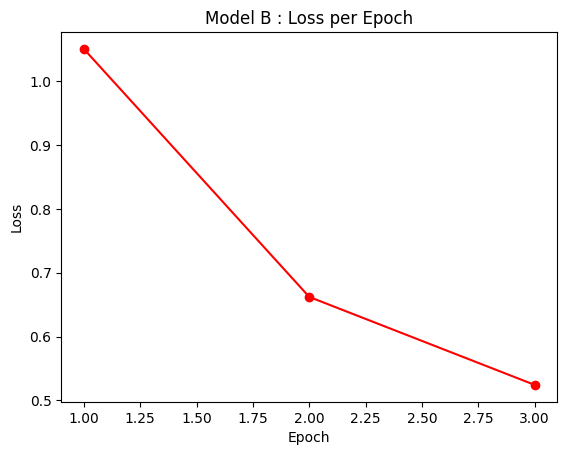

In [ ]:
# Plot the losses per epoch
plt.plot([i+1 for i in range(len(epoch_losses))], epoch_losses, 'r-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model B : Loss per Epoch')
plt.show()